# 灯条提取、装甲板匹配

In [1]:
"""
使用传统算法(灯条检测+匹配)自动标注装甲板数据
生成 YOLOv8-pose 格式的标注文件
"""

import cv2
import numpy as np
import os
from pathlib import Path
from typing import List, Tuple, Optional
import json
from tqdm import tqdm
from matplotlib import pyplot as plt

class Light:
    """灯条类"""
    def __init__(self, rotated_rect):
        self.center = rotated_rect[0]
        self.size = rotated_rect[1]
        self.angle = rotated_rect[2]
        
        # 计算长宽
        if self.size[0] < self.size[1]:
            self.width = self.size[0]
            self.length = self.size[1]
        else:
            self.width = self.size[1]
            self.length = self.size[0]
            self.angle += 90
        
        # 计算顶点 - 使用box顶点取平均(修复:取对边中点)
        box = cv2.boxPoints(rotated_rect)  # 获取旋转矩形的4个顶点
        box = np.array(box)
        
        # 按Y坐标排序,分为上下两组
        sorted_box = box[np.argsort(box[:, 1])]
        
        # 上边两个顶点的中点
        self.top = tuple(((sorted_box[0] + sorted_box[1]) / 2).astype(float))
        
        # 下边两个顶点的中点
        self.bottom = tuple(((sorted_box[2] + sorted_box[3]) / 2).astype(float))

class LightParams:
    """灯条筛选参数(参考C++代码)"""
    min_ratio = 0.01      # 最小宽长比
    max_ratio = 0.4      # 最大宽长比(从0.55降低到0.4,更严格)
    max_angle = 45       # 最大倾斜角度
    min_length = 10      # 最小长度(增加到10)
    min_width = 2        # 最小宽度

class ArmorParams:
    """装甲板筛选参数"""
    min_light_ratio = 0.8
    min_small_center_distance = 0.8
    max_small_center_distance = 3.2
    min_large_center_distance = 3.2
    max_large_center_distance = 5.5
    max_angle = 40
    max_armor_width = 300  # 装甲板最大宽度(像素) - 从200调整到300
    max_armor_height = 150  # 装甲板最大高度(像素) - 从200调整到150

class TraditionalArmorDetector:
    """传统装甲板检测器"""

    def __init__(self, binary_thresh=100):
        self.binary_thresh = binary_thresh
        self.l_params = LightParams()
        self.a_params = ArmorParams()
    
    def preprocess_image(self, gray_img):
        """图像预处理 - 二值化"""
        _, binary = cv2.threshold(gray_img, self.binary_thresh, 255, cv2.THRESH_BINARY)
        return binary
    
    def find_lights(self, binary_img) -> List[Light]:
        """查找灯条"""
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        lights = []
        for contour in contours:
            if len(contour) < 5:       
                continue
            
            r_rect = cv2.minAreaRect(contour)
            light = Light(r_rect)
            
            if not self.is_light(light):
                continue
            lights.append(light)
        
        return lights
    
    def is_light(self, light: Light) -> bool:
        """判断是否为有效灯条"""
        if light.length == 0:
            return False
        
        # 长宽比判断 - 灯条应该是细长的
        ratio = (light.width - 20) / light.length
        ratio_ok = self.l_params.min_ratio < (light.width / light.length) and ratio < self.l_params.max_ratio
        
        # 角度判断
        angle_ok = abs(light.angle) < self.l_params.max_angle
        
        # 尺寸判断 - 确保灯条足够长且有一定宽度
        size_ok = light.length >= self.l_params.min_length and light.width >= self.l_params.min_width
        
        return ratio_ok and angle_ok and size_ok
    
    def match_lights(self, lights: List[Light]) -> List[Tuple[Light, Light]]:
        """匹配灯条形成装甲板"""
        armors = []
        
        for i, light_1 in enumerate(lights):
            for light_2 in lights[i+1:]:
                if (self.containLight(light_1, light_2, lights)):
                    continue
                if self.is_armor(light_1, light_2):
                    armors.append((light_1, light_2))
        
        return armors
    
    def is_armor(self, light_1: Light, light_2: Light) -> bool:
        """判断两个灯条是否能组成装甲板"""
        # 1. 长度比例 - 两个灯条长度应该相近
        light_length_ratio = min(light_1.length, light_2.length) / max(light_1.length, light_2.length)
        if light_length_ratio < self.a_params.min_light_ratio:
            return False
        
        # 2. 灯条角度差 - 两个灯条应该接近平行
        angle_diff = abs(light_1.angle - light_2.angle)
        # 处理角度跨越180度的情况
        if angle_diff > 180:
            angle_diff = 360 - angle_diff
        if angle_diff > 15:  # 两灯条角度差不超过15度
            return False
        
        # 3. 中心距离检查
        avg_light_length = (light_1.length + light_2.length) / 2
        center_distance = np.linalg.norm(
            np.array(light_1.center) - np.array(light_2.center)
        ) / avg_light_length
        
        center_distance_ok = (
            (self.a_params.min_small_center_distance <= center_distance < self.a_params.max_small_center_distance) or
            (self.a_params.min_large_center_distance <= center_distance < self.a_params.max_large_center_distance)
        )
        
        if not center_distance_ok:
            return False
        
        # 4. 两灯条中心连线角度 - 应该接近水平(修复)
        diff = np.array(light_1.center) - np.array(light_2.center)
        center_angle = abs(np.arctan2(diff[1], diff[0])) / np.pi * 180
        # 只保留接近水平的: 0-45度 或 135-180度
        angle_ok = center_angle < self.a_params.max_angle or center_angle > (180 - self.a_params.max_angle)
        if not angle_ok:
            return False
        
        # 5. ROI大小检查
        point_distance_top = np.linalg.norm(np.array(light_1.top) - np.array(light_2.top))
        point_distance_bottom = np.linalg.norm(np.array(light_1.bottom) - np.array(light_2.bottom))
        
        if point_distance_top <= 16 or point_distance_bottom <= 16:
            return False
        
        # # 6. 装甲板尺寸限制
        # all_points = np.array([light_1.top, light_1.bottom, light_2.top, light_2.bottom])
        # armor_width = np.max(all_points[:, 0]) - np.min(all_points[:, 0])
        # armor_height = np.max(all_points[:, 1]) - np.min(all_points[:, 1])
        
        # # 宽度和高度限制
        # size_ok = (armor_width <= self.a_params.max_armor_width and 
        #         armor_height <= self.a_params.max_armor_height)
        
        # if not size_ok:
        #     return False
        
        # # 7. 长宽比限制(修复:允许接近正方形)
        # if armor_width > 0 and armor_height > 0:
        #     armor_aspect_ratio = armor_width / armor_height
        #     aspect_ratio_ok = 0.8 < armor_aspect_ratio < 5.0  # 从1.0改为0.8,允许接近正方形
        # else:
        #     aspect_ratio_ok = False
        
        return True

    def containLight(self, light_1, light_2, lights: List) -> bool:
        """
        检测两个灯条之间是否包含其他灯条
        
        参数:
            light_1: 第一个灯条对象
            light_2: 第二个灯条对象
            lights: 所有灯条的列表
        
        返回:
            bool: 如果包含其他灯条返回True,否则返回False
        """
        # 构造包含两个灯条顶点和底点的点集
        points = np.array([
            light_1.top,
            light_1.bottom,
            light_2.top,
            light_2.bottom
        ], dtype=np.float32)
        
        # 计算最小外接矩形
        bounding_rect = cv2.boundingRect(points)
        
        # 遍历所有灯条进行检测
        for test_light in lights:
            # 跳过当前配对的两个灯条
            if np.array_equal(test_light.center, light_1.center) or \
            np.array_equal(test_light.center, light_2.center):
                continue
            
            # 检查测试灯条的关键点是否在边界矩形内
            if self._point_in_rect(test_light.top, bounding_rect) or \
            self._point_in_rect(test_light.bottom, bounding_rect) or \
            self._point_in_rect(test_light.center, bounding_rect):
                return True
        
        return False        

    def detect(self, gray_img):
        """检测装甲板"""

        binary_img = self.preprocess_image(gray_img)
        lights = self.find_lights(binary_img)
        armors = self.match_lights(lights)
        
        return binary_img, armors, lights
    

    def _point_in_rect(self, point, rect) -> bool:
        """
        判断点是否在矩形内
        
        参数:
            point: (x, y) 坐标点
            rect: (x, y, width, height) 矩形
        
        返回:
            bool: 点在矩形内返回True
        """
        x, y, w, h = rect
        px, py = point
        return x <= px < x + w and y <= py < y + h

def visualize_annotation(img, lights, armors):
    """
    可视化：
    - 所有灯条：灰色
    - 能组成装甲板的灯条：绿色
    - 装甲板关键点：黄色
    - 装甲板连线：青色
    """
    vis_img = img.copy()

    # 1) 收集所有“参与装甲板”的灯条 id（用对象 id 做标记，避免 Light 没有 unique_id）
    used_lights = set()
    for (l1, l2) in armors:
        used_lights.add(id(l1))
        used_lights.add(id(l2))

    # 2) 先画所有灯条
    for l in lights:
        p1 = tuple(map(int, l.top))
        p2 = tuple(map(int, l.bottom))
        cv2.line(vis_img, p1, p2, (0, 0, 255), 2)

    # 3) 再把“参与装甲板”的灯条覆盖画出来（绿色更醒目）
    for l in lights:
        if id(l) not in used_lights:
            continue
        p1 = tuple(map(int, l.top))
        p2 = tuple(map(int, l.bottom))
        cv2.line(vis_img, p1, p2, (0, 255, 0), 3)

    # 4) 画装甲板连线 + 关键点
    for (light_1, light_2) in armors:
        # 确保 light_1 在左边
        if light_1.center[0] > light_2.center[0]:
            light_1, light_2 = light_2, light_1

        # 装甲板上下边（青色）
        cv2.line(
            vis_img,
            tuple(map(int, light_1.top)),
            tuple(map(int, light_2.top)),
            (255, 255, 0),
            2,
        )
        cv2.line(
            vis_img,
            tuple(map(int, light_1.bottom)),
            tuple(map(int, light_2.bottom)),
            (255, 255, 0),
            2,
        )

        # 关键点（黄色）
        keypoints = [light_1.top, light_1.bottom, light_2.bottom, light_2.top]
        for i, kp in enumerate(keypoints):
            cv2.circle(vis_img, tuple(map(int, kp)), 5, (0, 255, 255), -1)
            cv2.putText(
                vis_img,
                str(i),
                tuple(map(int, kp)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 255),
                1,
            )

    return vis_img

找到 4074 张图像

[1/4074] 0524_160835_11_0.bmp
检测到 8 个灯条, 1 个装甲板


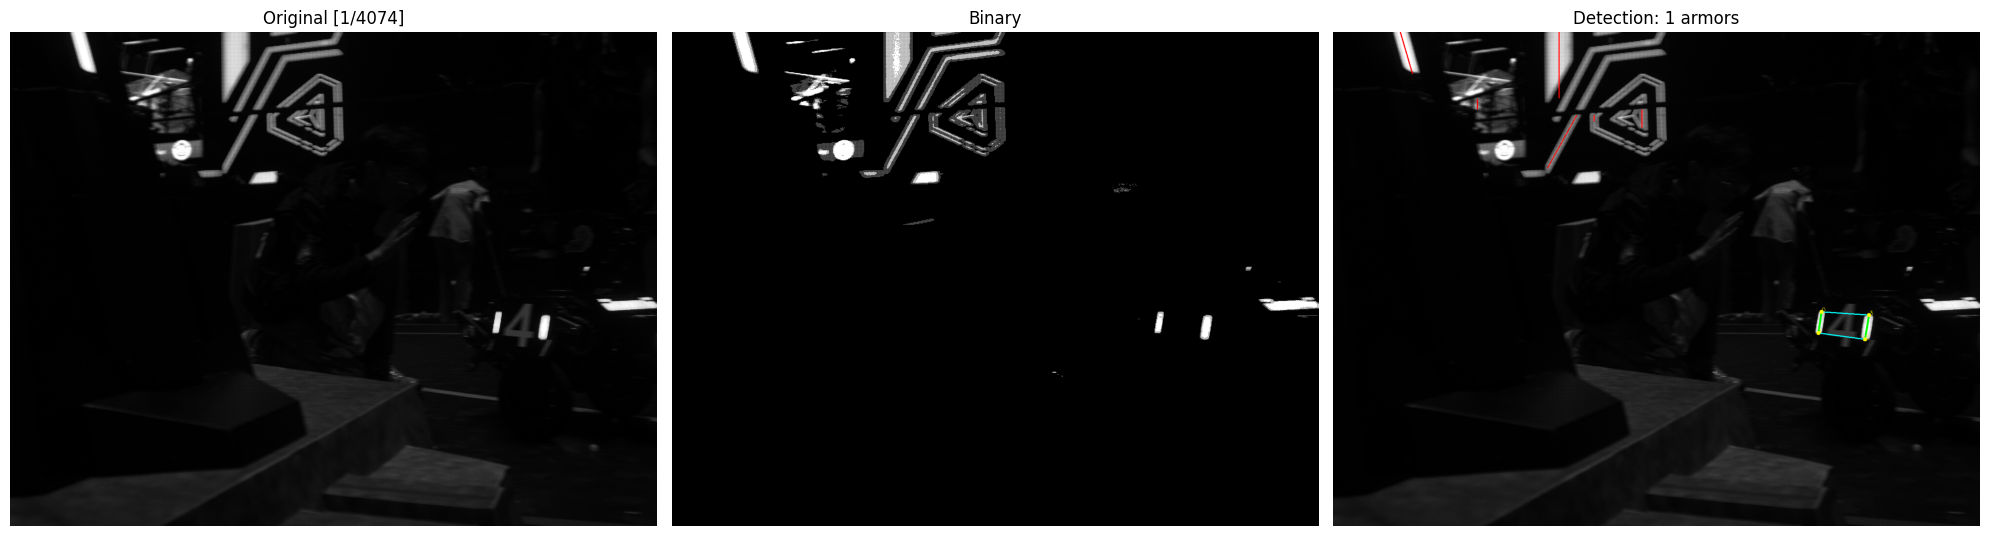


使用方法:
  viewer.next()  - 下一张 (或简写: viewer.next())
  viewer.prev()  - 上一张
  viewer.goto(10) - 跳转到第11张
  viewer.show_current() - 重新显示当前图像


In [2]:
class ImageViewer:
    """交互式图像浏览器"""
    def __init__(self, image_dir, detector):
        self.image_dir = Path(image_dir)
        self.detector = detector
        
        # 获取所有图像文件
        self.image_files = []
        for ext in ['*.bmp', '*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(sorted(self.image_dir.glob(f'**/{ext}')))
        
        self.current_index = 0
        self.total_images = len(self.image_files)
        
        print(f"找到 {self.total_images} 张图像")
        
    def show_current(self):
        """显示当前图像"""
        if self.total_images == 0:
            print("没有找到图像文件")
            return
        
        img_path = self.image_files[self.current_index]
        print(f"\n[{self.current_index + 1}/{self.total_images}] {img_path.name}")
        
        # 读取并检测
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"无法读取图像: {img_path}")
            return
        
        binary_img, armors, lights = self.detector.detect(image)
        print(f"检测到 {len(lights)} 个灯条, {len(armors)} 个装甲板")
        
        # 可视化
        image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        vis_img = visualize_annotation(image_bgr, lights, armors)
        
        # 显示
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original [{self.current_index + 1}/{self.total_images}]')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(binary_img, cmap='gray')
        plt.title('Binary')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection: {len(armors)} armors')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    def next(self):
        """下一张"""
        if self.current_index < self.total_images - 1:
            self.current_index += 1
            self.show_current()
        else:
            print("已经是最后一张了")
    
    def prev(self):
        """上一张"""
        if self.current_index > 0:
            self.current_index -= 1
            self.show_current()
        else:
            print("已经是第一张了")
    
    def goto(self, index):
        """跳转到指定索引"""
        if 0 <= index < self.total_images:
            self.current_index = index
            self.show_current()
        else:
            print(f"索引超出范围: 0-{self.total_images - 1}")

detector = TraditionalArmorDetector(binary_thresh=100)

# 创建浏览器实例
viewer = ImageViewer(
    image_dir="/home/wangfeng/RM2026/amor_data/competation/5-24/3",
    detector=detector
)

# 显示第一张
viewer.show_current()

print("\n使用方法:")
print("  viewer.next()  - 下一张 (或简写: viewer.next())")
print("  viewer.prev()  - 上一张")
print("  viewer.goto(10) - 跳转到第11张")
print("  viewer.show_current() - 重新显示当前图像")


[237/4697] 0525_102917_331496_236.bmp
检测到 24 个灯条, 5 个装甲板


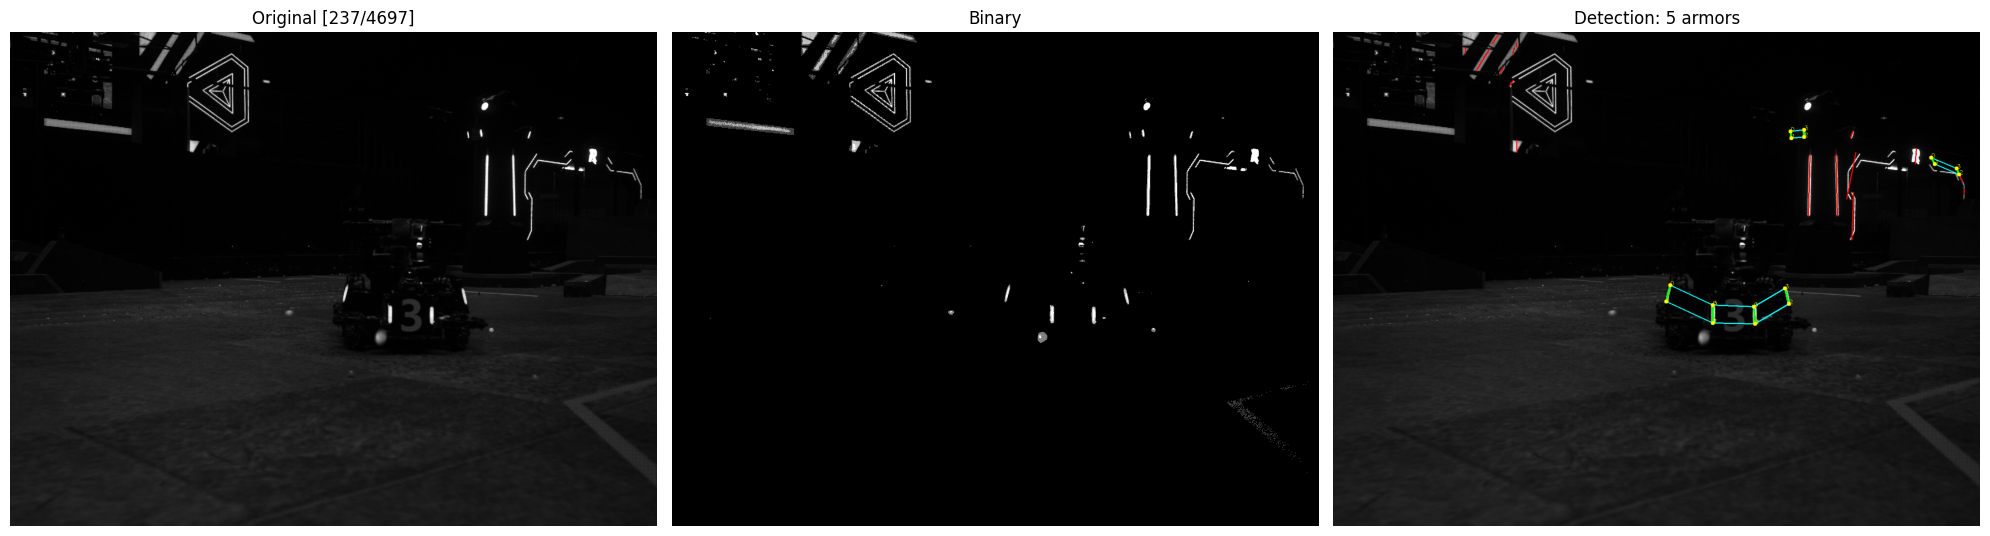

In [144]:
# 🔽 运行这个 Cell 查看下一张图像
viewer.next()


[228/4697] 0525_102915_329695_227.bmp
检测到 10 个灯条, 5 个装甲板


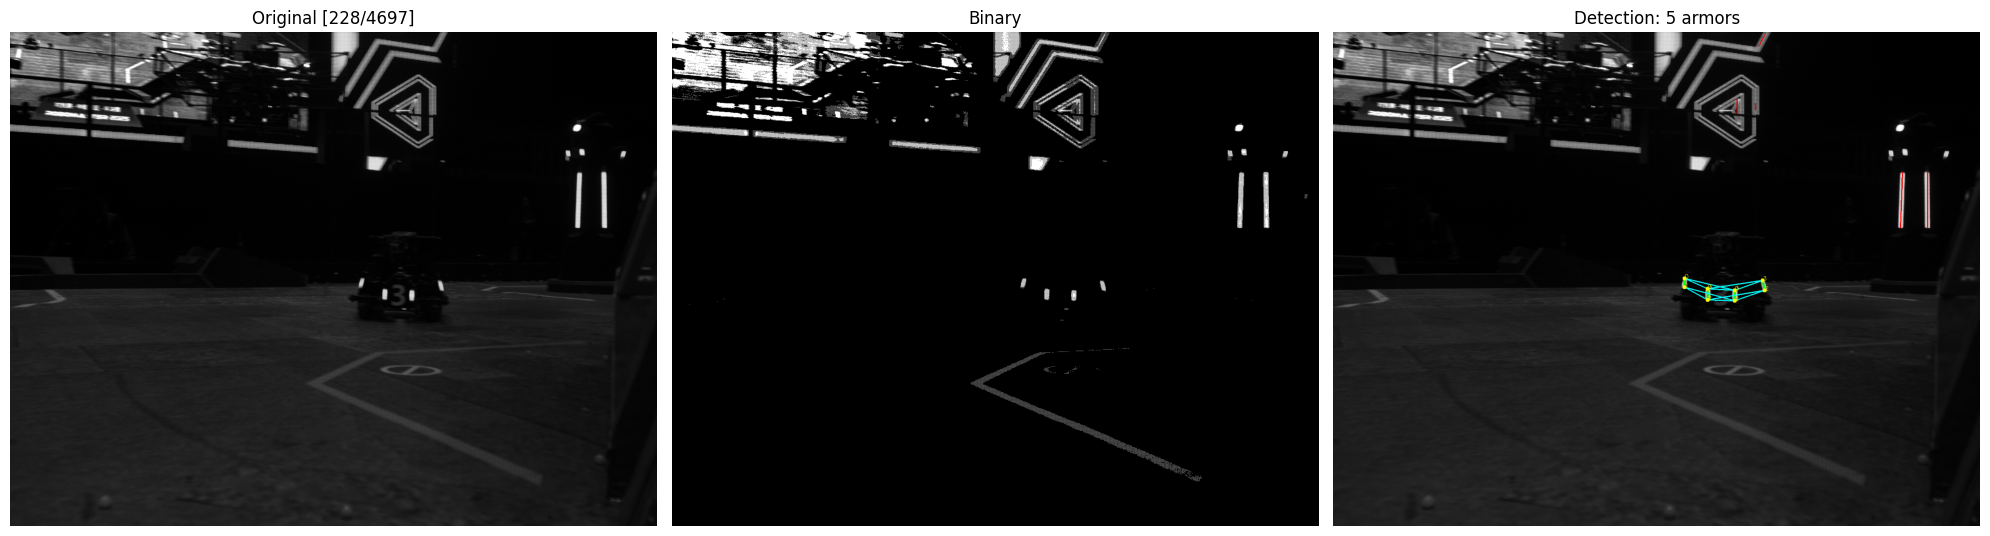

In [61]:
# 🔼 运行这个 Cell 查看上一张图像
viewer.prev()


[1595/4074] 0524_163016_1300957_1594.bmp
检测到 9 个灯条, 1 个装甲板


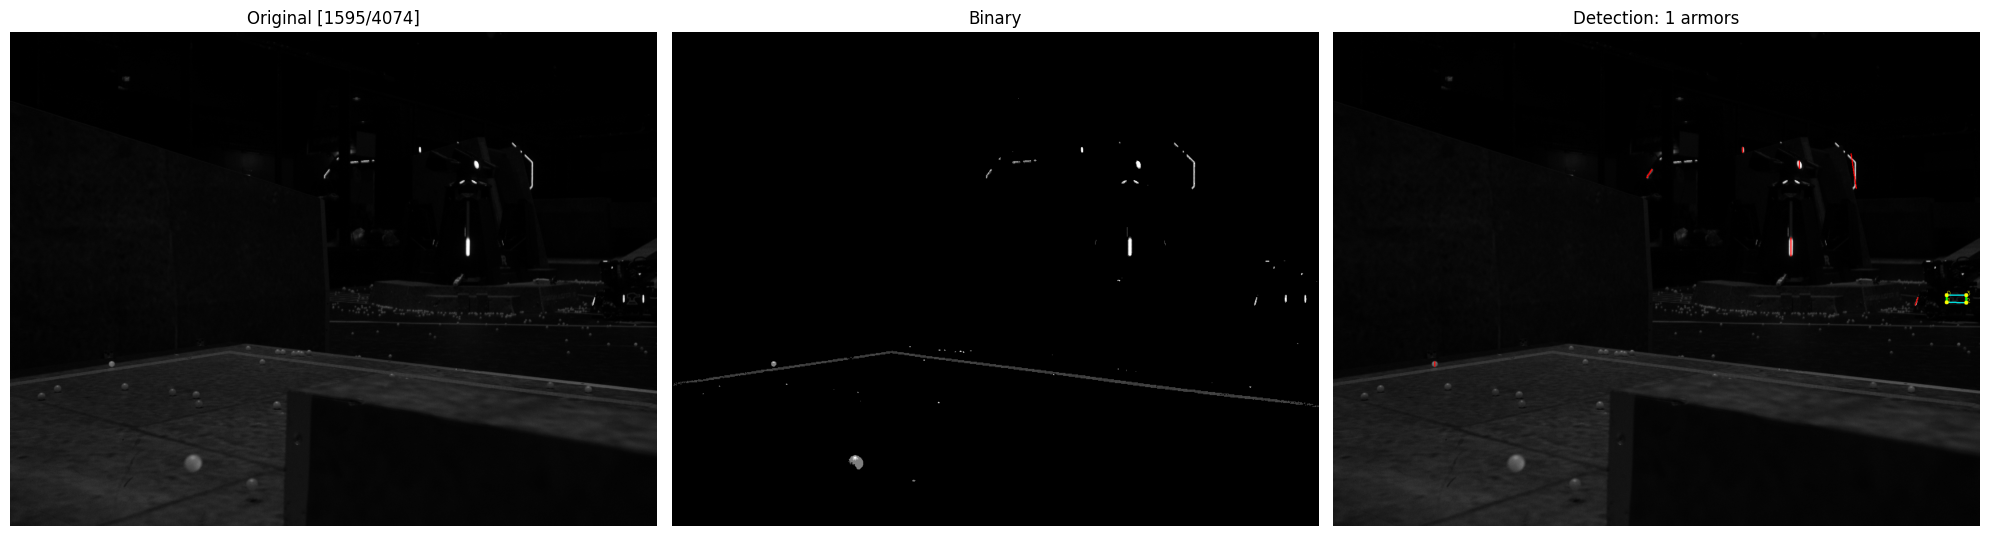

In [3]:
# 🎯 修改数字跳转到指定图像 (例如: 跳到第50张)
viewer.goto(1594)  # 索引从0开始,49表示第50张

## 🔧 调试工具

如果检测结果不理想,可以使用下面的调试工具查看详细信息

In [6]:
# 📊 调试模式:显示详细的匹配信息
class DebugArmorDetector(TraditionalArmorDetector):
    def is_armor(self, light_1: Light, light_2: Light) -> bool:
        """带调试信息的装甲板判断"""
        print(f"\n检查灯条对: L1({light_1.center[0]:.1f},{light_1.center[1]:.1f}) <-> L2({light_2.center[0]:.1f},{light_2.center[1]:.1f})")
        
        # 1. 长度比例
        light_length_ratio = min(light_1.length, light_2.length) / max(light_1.length, light_2.length)
        print(f"  ✓ 长度比例: {light_length_ratio:.2f} (>= {self.a_params.min_light_ratio})")
        if light_length_ratio < self.a_params.min_light_ratio:
            print("    ❌ 不通过")
            return False
        
        # 2. 角度差
        angle_diff = abs(light_1.angle - light_2.angle)
        if angle_diff > 180:
            angle_diff = 360 - angle_diff
        print(f"  ✓ 角度差: {angle_diff:.1f}° (<= 15°)")
        if angle_diff > 15:
            print("    ❌ 不通过")
            return False
        
        # 3. 中心距离
        avg_light_length = (light_1.length + light_2.length) / 2
        center_distance = np.linalg.norm(
            np.array(light_1.center) - np.array(light_2.center)
        ) / avg_light_length
        print(f"  ✓ 归一化距离: {center_distance:.2f} (0.8-3.2小板 或 3.2-5.5大板)")
        
        center_distance_ok = (
            (self.a_params.min_small_center_distance <= center_distance < self.a_params.max_small_center_distance) or
            (self.a_params.min_large_center_distance <= center_distance < self.a_params.max_large_center_distance)
        )
        if not center_distance_ok:
            print("    ❌ 不通过")
            return False
        
        # 4. 连线角度
        diff = np.array(light_1.center) - np.array(light_2.center)
        center_angle = abs(np.arctan2(diff[1], diff[0])) / np.pi * 180
        print(f"  ✓ 连线角度: {center_angle:.1f}° (应 <45° 或 >135°)")
        angle_ok = center_angle < self.a_params.max_angle or center_angle > (180 - self.a_params.max_angle)
        if not angle_ok:
            print("    ❌ 不通过")
            return False
        
        # 5. ROI检查
        point_distance_top = np.linalg.norm(np.array(light_1.top) - np.array(light_2.top))
        point_distance_bottom = np.linalg.norm(np.array(light_1.bottom) - np.array(light_2.bottom))
        print(f"  ✓ 顶点距离: top={point_distance_top:.1f}, bottom={point_distance_bottom:.1f} (>16)")
        if point_distance_top <= 16 or point_distance_bottom <= 16:
            print("    ❌ 不通过")
            return False
        
        # 6. 尺寸限制
        all_points = np.array([light_1.top, light_1.bottom, light_2.top, light_2.bottom])
        armor_width = np.max(all_points[:, 0]) - np.min(all_points[:, 0])
        armor_height = np.max(all_points[:, 1]) - np.min(all_points[:, 1])
        print(f"  ✓ 装甲板尺寸: {armor_width:.1f}x{armor_height:.1f} (<={self.a_params.max_armor_width}x{self.a_params.max_armor_height})")
        
        size_ok = (armor_width <= self.a_params.max_armor_width and 
                armor_height <= self.a_params.max_armor_height)
        if not size_ok:
            print("    ❌ 不通过")
            return False
        
        # 7. 长宽比
        if armor_width > 0 and armor_height > 0:
            armor_aspect_ratio = armor_width / armor_height
            print(f"  ✓ 长宽比: {armor_aspect_ratio:.2f} (0.8-5.0)")
            aspect_ratio_ok = 0.8 < armor_aspect_ratio < 5.0
        else:
            aspect_ratio_ok = False
        
        if aspect_ratio_ok:
            print("  ✅ 通过所有检查,匹配成功!")
        else:
            print("    ❌ 不通过")
        
        return aspect_ratio_ok

# 使用调试模式检测当前图像
print("=" * 60)
print("调试模式检测")
print("=" * 60)
debug_detector = DebugArmorDetector(binary_thresh=100)
image_path = viewer.image_files[viewer.current_index]
image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
binary_img, armors, lights = debug_detector.detect(image)
print(f"\n最终结果: 检测到 {len(lights)} 个灯条, {len(armors)} 个装甲板")

调试模式检测

检查灯条对: L1(547.0,829.0) <-> L2(1097.4,817.9)
  ✓ 长度比例: 0.23 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(861.1,775.7)
  ✓ 长度比例: 0.23 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(796.8,765.2)
  ✓ 长度比例: 0.27 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(617.5,359.0)
  ✓ 长度比例: 1.00 (>= 0.7)
  ✓ 角度差: 0.0° (<= 15°)
  ✓ 归一化距离: 39.60 (0.8-3.2小板 或 3.2-5.5大板)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(673.5,230.0)
  ✓ 长度比例: 0.75 (>= 0.7)
  ✓ 角度差: 0.0° (<= 15°)
  ✓ 归一化距离: 43.73 (0.8-3.2小板 或 3.2-5.5大板)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(19.0,189.0)
  ✓ 长度比例: 1.00 (>= 0.7)
  ✓ 角度差: 0.0° (<= 15°)
  ✓ 归一化距离: 69.14 (0.8-3.2小板 或 3.2-5.5大板)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(623.5,171.5)
  ✓ 长度比例: 0.28 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(668.5,52.6)
  ✓ 长度比例: 0.22 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(749.1,26.7)
  ✓ 长度比例: 0.30 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(547.0,829.0) <-> L2(518.0,264.3)
  ✓ 长度比例: 0.02 (>= 0.7)
    ❌ 不通过

检查灯条对: L1(1097.4,817.9

# 🤖 MLP数字分类器

本部分实现装甲板数字的识别，流程参考C++代码的`NumberClassifier`类：

### 📋 完整流程
1. **ROI提取**: 从匹配的装甲板中提取数字区域
   - 透视变换：将倾斜的装甲板矫正为水平矩形
   - 裁剪中心区域：获取20x28的数字ROI

2. **图像预处理**: 
   - 灰度直方图均衡化 (`cv2.equalizeHist`)
   - 归一化到[0,1]
   - 转换为Batch格式 (1, 1, H, W)

3. **ONNX推理**:
   - 输入: (1, 1, 28, 20) 的灰度图像
   - 输出: 类别概率分布
   - Softmax后处理获取最终置信度

4. **结果过滤**:
   - 置信度阈值过滤
   - 装甲板类型与数字匹配检查

---

## 一、roi提取
根据匹配的装甲板，提取roi区域，并将图像resize到20*28

测试ROI提取
检测到 1 个装甲板
成功提取 1 个ROI区域


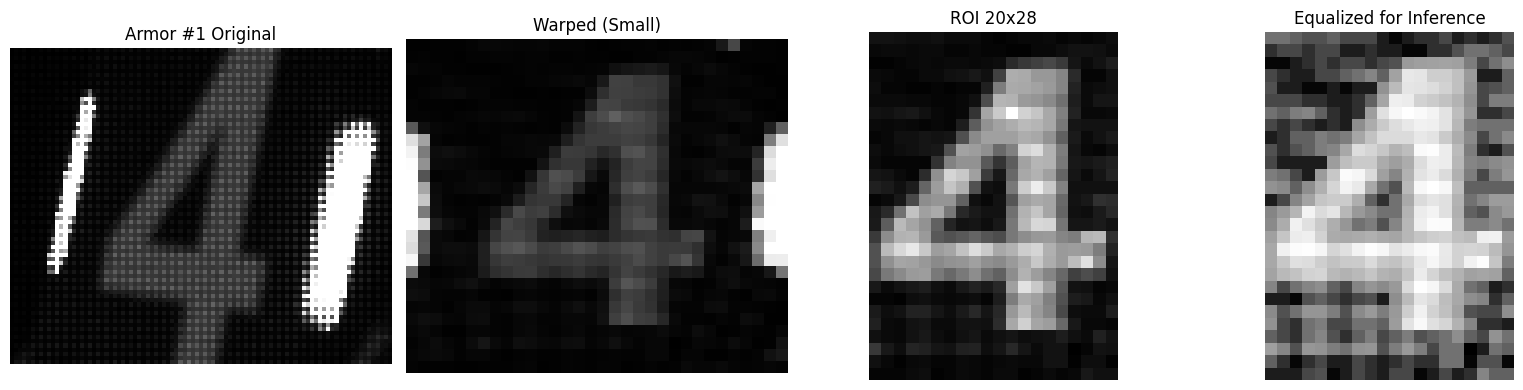

In [7]:
def extract_number_rois(src_img, armors):
    """
    提取装甲板数字ROI区域
    参考C++代码的extractNumbers方法
    
    Args:
        src_img: 原始灰度图像
        armors: 装甲板列表 [(light_1, light_2), ...]
    
    Returns:
        roi_images: 提取的ROI图像列表
        armor_infos: 装甲板信息列表(用于后续标注)
    """
    # 参数设置(参考C++代码)
    LIGHT_LENGTH = 12          # 变换后灯条长度
    WARP_HEIGHT = 28           # 变换后图像高度
    SMALL_ARMOR_WIDTH = 32     # 小装甲板宽度
    LARGE_ARMOR_WIDTH = 54     # 大装甲板宽度
    ROI_SIZE = (20, 28)        # 数字ROI尺寸 (width, height)
    
    roi_images = []
    armor_infos = []
    
    for light_1, light_2 in armors:
        # 确保light_1在左边
        if light_1.center[0] > light_2.center[0]:
            light_1, light_2 = light_2, light_1
        
        # 判断装甲板类型(根据归一化距离)
        avg_light_length = (light_1.length + light_2.length) / 2
        center_distance = np.linalg.norm(
            np.array(light_1.center) - np.array(light_2.center)
        ) / avg_light_length
        
        # 根据距离判断大小板
        is_large = center_distance >= 3.2
        warp_width = LARGE_ARMOR_WIDTH if is_large else SMALL_ARMOR_WIDTH
        
        # 源图像四个顶点(按照C++代码的顺序: left_bottom, left_top, right_top, right_bottom)
        lights_vertices = np.float32([
            light_1.bottom,  # 左下
            light_1.top,     # 左上
            light_2.top,     # 右上
            light_2.bottom   # 右下
        ])
        
        # 目标图像四个顶点
        top_light_y = (WARP_HEIGHT - LIGHT_LENGTH) / 2 - 1
        bottom_light_y = top_light_y + LIGHT_LENGTH
        
        target_vertices = np.float32([
            [0, bottom_light_y],                    # 左下
            [0, top_light_y],                       # 左上
            [warp_width - 1, top_light_y],          # 右上
            [warp_width - 1, bottom_light_y]        # 右下
        ])
        
        # 透视变换
        rotation_matrix = cv2.getPerspectiveTransform(lights_vertices, target_vertices)
        number_image = cv2.warpPerspective(src_img, rotation_matrix, (warp_width, WARP_HEIGHT))
        
        # 裁剪ROI区域(从中心裁剪)
        roi_x = (warp_width - ROI_SIZE[0]) // 2
        roi_y = 0
        number_roi = number_image[roi_y:roi_y + ROI_SIZE[1], roi_x:roi_x + ROI_SIZE[0]]
        
        # 保存ROI图像和装甲板信息
        roi_images.append(number_roi)
        armor_infos.append({
            'light_1': light_1,
            'light_2': light_2,
            'is_large': is_large,
            'warp_image': number_image,  # 保存完整变换图像用于可视化
            'roi': number_roi
        })
    
    return roi_images, armor_infos


def visualize_roi_extraction(src_img, armors, roi_images, armor_infos):
    """
    可视化ROI提取过程
    """
    n_armors = len(armors)
    if n_armors == 0:
        print("没有检测到装甲板")
        return
    
    # 创建图像网格
    fig, axes = plt.subplots(n_armors, 4, figsize=(16, 4 * n_armors))
    if n_armors == 1:
        axes = axes.reshape(1, -1)
    
    for i, (armor, roi_img, info) in enumerate(zip(armors, roi_images, armor_infos)):
        light_1, light_2 = armor
        
        # 1. 原始装甲板区域
        all_points = np.array([light_1.top, light_1.bottom, light_2.top, light_2.bottom])
        x_min, y_min = np.min(all_points, axis=0).astype(int)
        x_max, y_max = np.max(all_points, axis=0).astype(int)
        
        # 扩展边界
        margin = 10
        x_min = max(0, x_min - margin)
        y_min = max(0, y_min - margin)
        x_max = min(src_img.shape[1], x_max + margin)
        y_max = min(src_img.shape[0], y_max + margin)
        
        armor_crop = src_img[y_min:y_max, x_min:x_max].copy()
        
        axes[i, 0].imshow(armor_crop, cmap='gray')
        axes[i, 0].set_title(f'Armor #{i+1} Original')
        axes[i, 0].axis('off')
        
        # 2. 透视变换后的完整图像
        axes[i, 1].imshow(info['warp_image'], cmap='gray')
        axes[i, 1].set_title(f'Warped ({"Large" if info["is_large"] else "Small"})')
        axes[i, 1].axis('off')
        
        # 3. 提取的ROI
        axes[i, 2].imshow(roi_img, cmap='gray')
        axes[i, 2].set_title(f'ROI {roi_img.shape[1]}x{roi_img.shape[0]}')
        axes[i, 2].axis('off')
        
        # 4. 直方图均衡化后的ROI(用于推理)
        roi_equalized = cv2.equalizeHist(roi_img)
        axes[i, 3].imshow(roi_equalized, cmap='gray')
        axes[i, 3].set_title('Equalized for Inference')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()


# 测试ROI提取
print("="*60)
print("测试ROI提取")
print("="*60)

# 获取当前图像
image_path = viewer.image_files[viewer.current_index]
image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

# 检测装甲板
binary_img, armors, lights = detector.detect(image)
print(f"检测到 {len(armors)} 个装甲板")

if len(armors) > 0:
    # 提取ROI
    roi_images, armor_infos = extract_number_rois(image, armors)
    print(f"成功提取 {len(roi_images)} 个ROI区域")
    
    # 可视化
    visualize_roi_extraction(image, armors, roi_images, armor_infos)
else:
    print("未检测到装甲板，无法提取ROI")

## 三、推理与分类

### 3.1 准备工作

在进行推理之前，需要确保以下文件存在：

1. **ONNX模型文件**: `model/cnn.onnx`
2. **标签文件**: `model/label.txt` (每行一个类别名)


In [8]:
from pathlib import Path

label_file = Path("/home/wangfeng/RM2026/amor_data/python_refactor/model/label.txt")

# 检查模型文件
model_file = Path("/home/wangfeng/RM2026/amor_data/python_refactor/model/cnn.onnx")
if model_file.exists():
    print(f"\n✅ 模型文件已存在: {model_file}")
    print(f"   文件大小: {model_file.stat().st_size / 1024:.2f} KB")
else:
    print(f"\n⚠️  模型文件不存在: {model_file}")
    print("   请确保模型文件存在后再运行推理")


✅ 模型文件已存在: /home/wangfeng/RM2026/amor_data/python_refactor/model/cnn.onnx
   文件大小: 304.20 KB


### 3.2 数字分类器实现

In [9]:
import onnxruntime
import json

class NumberClassifier:
    """
    装甲板数字分类器
    参考C++代码的classify方法
    """
    def __init__(self, model_path, label_path, threshold=0.7):
        """
        Args:
            model_path: ONNX模型路径
            label_path: 标签文件路径(每行一个类别名)
            threshold: 置信度阈值
        """
        self.threshold = threshold
        
        # 加载ONNX模型
        self.ort_session = onnxruntime.InferenceSession(model_path)
        
        # 加载类别名
        self.class_names = []
        with open(label_path, 'r') as f:
            for line in f:
                self.class_names.append(line.strip())
        
        print(f"加载模型: {model_path}")
        print(f"类别数量: {len(self.class_names)}")
        print(f"类别: {self.class_names}")
        
        # 打印模型输入信息
        input_info = self.ort_session.get_inputs()[0]
        print(f"\n模型输入名称: {input_info.name}")
        print(f"模型期望形状: {input_info.shape}")
    
    def preprocess(self, roi_img):
        """
        图像预处理 - 完全复刻C++的blobFromImage行为
        
        C++代码:
        cv::dnn::blobFromImage(image, blob, 1.0/255, cv::Size(28, 20), ...)
        
        注意:
        1. ROI输入是 (28, 20) 的灰度图 - (height, width)
        2. cv::Size(28, 20) 表示 width=28, height=20，会先resize
        3. 最终blob形状: (1, 1, 20, 28) - (batch, channels, height, width)
        """
        # 1. 直方图均衡化
        img_eq = cv2.equalizeHist(roi_img)
        
        # 2. Resize到指定尺寸 (模拟 cv::Size(28, 20) 的效果)
        # cv::Size(width, height) = cv::Size(28, 20)
        # OpenCV resize 参数是 (width, height)
        img_resized = cv2.resize(img_eq, (28, 20), interpolation=cv2.INTER_LINEAR)
        # 现在 img_resized.shape = (20, 28) - (height, width)
        
        # 3. 归一化到[0,1]
        img_normalized = img_resized.astype(np.float32) / 255.0
        
        # 4. 转换为NCHW格式 (batch, channels, height, width)
        # (20, 28) -> (1, 1, 20, 28)
        blob = img_normalized[np.newaxis, np.newaxis, :, :]
        
        return blob
    
    def classify_single(self, roi_img):
        """
        分类单个ROI图像
        
        Returns:
            class_name: 类别名
            confidence: 置信度
        """
        # 预处理
        blob = self.preprocess(roi_img)
        
        # 推理
        ort_inputs = {self.ort_session.get_inputs()[0].name: blob}
        outputs = self.ort_session.run(None, ort_inputs)[0]
        
        # Softmax(参考C++代码)
        max_prob = np.max(outputs)
        softmax_prob = np.exp(outputs - max_prob)
        softmax_prob = softmax_prob / np.sum(softmax_prob)
        
        # 获取最大置信度的类别
        class_id = np.argmax(softmax_prob)
        confidence = softmax_prob[0, class_id]
       

### 3.3 调试分类器

如果分类结果不正确，使用下面的工具查看详细的概率分布


💡 运行详细调试，查看每个装甲板的完整分类信息...

🔍 详细分类调试

检测到 3 个装甲板
加载模型: /home/wangfeng/RM2026/amor_data/python_refactor/model/cnn.onnx
类别数量: 7
类别: ['guard', '1', '2', '3', '4', 'outpost', 'negative']

模型输入名称: input
模型期望形状: ['batch_size', 1, 20, 28]

🎯 装甲板 #1 (小板)

ROI原始形状: (28, 20)
Blob输入形状: (1, 1, 20, 28)
Blob值范围: [0.000, 1.000]

原始输出 (logits): [ 0.36967164 -1.2840499  -3.4398031  -4.0879755  -3.364203   -3.6042566
  2.6535501 ]

各类别置信度:
    negative:  88.6% ████████████████████████████████████████████
       guard:   9.0% ████
           1:   1.7% 
           4:   0.2% 
           2:   0.2% 
     outpost:   0.2% 
           3:   0.1% 

✅ 最终预测: negative (置信度: 88.6%)


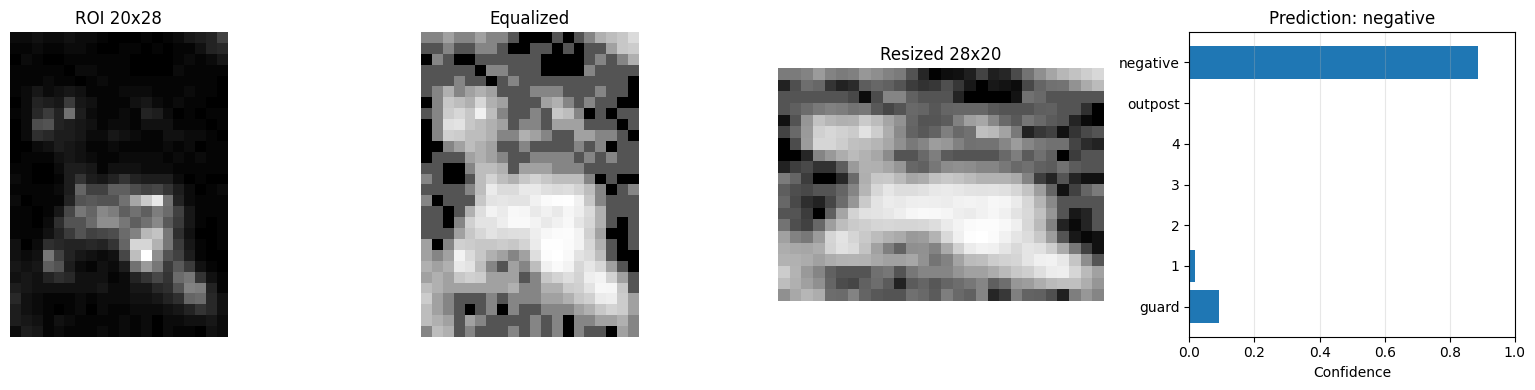


🎯 装甲板 #2 (大板)

ROI原始形状: (28, 20)
Blob输入形状: (1, 1, 20, 28)
Blob值范围: [0.000, 0.992]

原始输出 (logits): [-3.0929766 -2.1355379 -3.6006992 -2.0319693 -3.0491498 -3.9547122
  3.689635 ]

各类别置信度:
    negative:  99.0% █████████████████████████████████████████████████
           3:   0.3% 
           1:   0.3% 
           4:   0.1% 
       guard:   0.1% 
           2:   0.1% 
     outpost:   0.0% 

✅ 最终预测: negative (置信度: 99.0%)


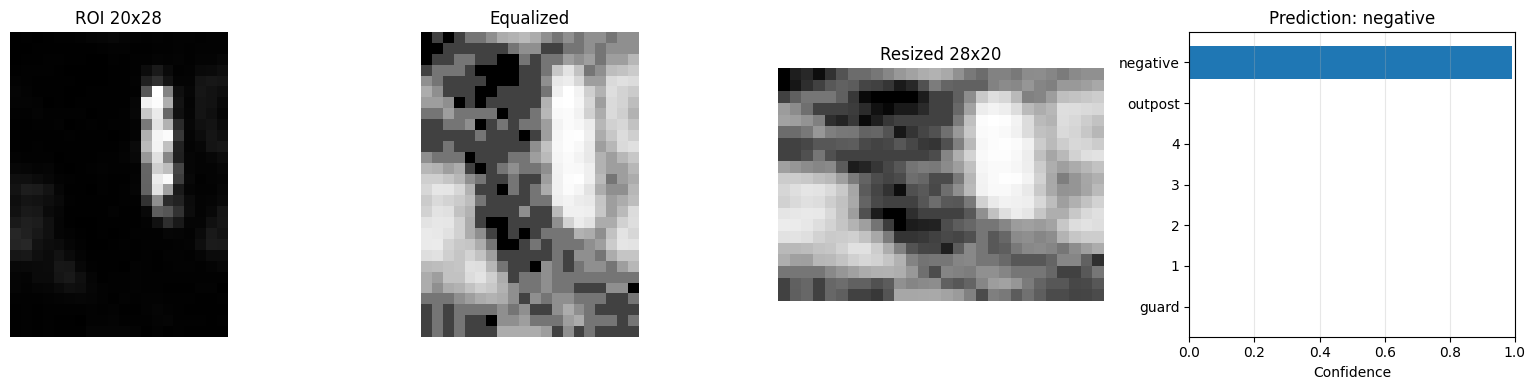


🎯 装甲板 #3 (小板)

ROI原始形状: (28, 20)
Blob输入形状: (1, 1, 20, 28)
Blob值范围: [0.000, 1.000]

原始输出 (logits): [ 7.1467686 -4.297727  -1.8516575 -2.660898  -3.260997  -1.5967456
 -1.7632153]

各类别置信度:
       guard:  99.9% █████████████████████████████████████████████████
     outpost:   0.0% 
    negative:   0.0% 
           2:   0.0% 
           3:   0.0% 
           4:   0.0% 
           1:   0.0% 

✅ 最终预测: guard (置信度: 99.9%)


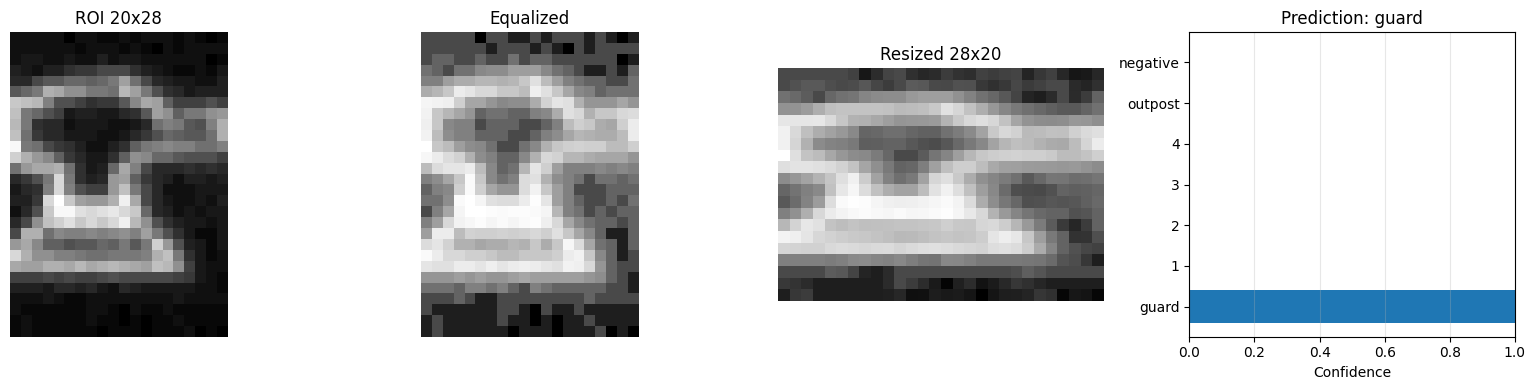

In [10]:
class DebugNumberClassifier(NumberClassifier):
    """带调试信息的数字分类器"""
    
    def classify_single_debug(self, roi_img):
        """
        分类单个ROI并返回所有类别的概率
        """
        # 预处理
        blob = self.preprocess(roi_img)
        
        print(f"\nROI原始形状: {roi_img.shape}")
        print(f"Blob输入形状: {blob.shape}")
        print(f"Blob值范围: [{blob.min():.3f}, {blob.max():.3f}]")
        
        # 推理
        ort_inputs = {self.ort_session.get_inputs()[0].name: blob}
        outputs = self.ort_session.run(None, ort_inputs)[0]
        
        print(f"\n原始输出 (logits): {outputs[0]}")
        
        # Softmax
        max_prob = np.max(outputs)
        softmax_prob = np.exp(outputs - max_prob)
        softmax_prob = softmax_prob / np.sum(softmax_prob)
        
        # 显示所有类别的概率
        print(f"\n各类别置信度:")
        probs = softmax_prob[0]
        sorted_indices = np.argsort(probs)[::-1]  # 降序排列
        
        for idx in sorted_indices:
            class_name = self.class_names[idx]
            confidence = probs[idx]
            bar = '█' * int(confidence * 50)
            print(f"  {class_name:>10s}: {confidence*100:5.1f}% {bar}")
        
        # 返回top-1结果
        class_id = np.argmax(probs)
        return self.class_names[class_id], float(probs[class_id]), probs


def debug_classify_current_image():
    """
    详细调试当前图像的分类过程
    """
    print("="*60)
    print("🔍 详细分类调试")
    print("="*60)
    
    # 获取当前图像
    image_path = "/home/wangfeng/RM2026/amor_data/competation/5-24/3/images_0524_1608/0524_162935_1259126_1436.bmp"
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    
    # 检测装甲板
    binary_img, armors, lights = detector.detect(image)
    print(f"\n检测到 {len(armors)} 个装甲板")
    
    if len(armors) == 0:
        print("未检测到装甲板")
        return
    
    # 提取ROI
    roi_images, armor_infos = extract_number_rois(image, armors)
    
    # 创建调试分类器
    try:
        debug_classifier = DebugNumberClassifier(model_path, label_path, threshold=0.6)
        
        # 为每个装甲板显示详细信息
        for i, (roi_img, info) in enumerate(zip(roi_images, armor_infos)):
            print(f"\n{'='*60}")
            print(f"🎯 装甲板 #{i+1} ({'大板' if info['is_large'] else '小板'})")
            print(f"{'='*60}")
            
            class_name, confidence, all_probs = debug_classifier.classify_single_debug(roi_img)
            
            print(f"\n✅ 最终预测: {class_name} (置信度: {confidence*100:.1f}%)")
            
            # 显示ROI图像
            plt.figure(figsize=(16, 4))
            
            # 原始ROI
            plt.subplot(1, 4, 1)
            plt.imshow(roi_img, cmap='gray')
            plt.title(f'ROI {roi_img.shape[1]}x{roi_img.shape[0]}')
            plt.axis('off')
            
            # 均衡化后的ROI
            plt.subplot(1, 4, 2)
            roi_eq = cv2.equalizeHist(roi_img)
            plt.imshow(roi_eq, cmap='gray')
            plt.title('Equalized')
            plt.axis('off')
            
            # Resize后的图像
            plt.subplot(1, 4, 3)
            roi_resized = cv2.resize(roi_eq, (28, 20))
            plt.imshow(roi_resized, cmap='gray')
            plt.title(f'Resized {roi_resized.shape[1]}x{roi_resized.shape[0]}')
            plt.axis('off')
            
            # 概率分布柱状图
            plt.subplot(1, 4, 4)
            plt.barh(range(len(debug_classifier.class_names)), all_probs)
            plt.yticks(range(len(debug_classifier.class_names)), debug_classifier.class_names)
            plt.xlabel('Confidence')
            plt.title(f'Prediction: {class_name}')
            plt.xlim(0, 1)
            plt.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"\n错误: {e}")
        import traceback
        traceback.print_exc()


# 运行详细调试
print("\n💡 运行详细调试，查看每个装甲板的完整分类信息...\n")
model_path = "/home/wangfeng/RM2026/amor_data/python_refactor/model/cnn.onnx"
label_path = "/home/wangfeng/RM2026/amor_data/python_refactor/model/label.txt"
debug_classify_current_image()